# UKESM Temperature profile mask
The purpose of this notebook is to create a mask to remove all land based data points and Nans at a depth of 2000 m from the UKESM temperature data from historic simulations. To do this the notebook takes imports a prior mask calculated in v1.0.

The [mask calculation and creation](#Calculating-the-mask) can be found in the bottom half of the document.

TODO:
Plot masks in orthographic projection.

#### Dask Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41487")
client

Client Scheduler: tcp://127.0.0.1:41487 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 25.77 GB


<br>

#### Choices for data

In [2]:
#Ocean Area data for averaging
areaActivityId = 'CMIP'
areaMemberId = "r1i1p1f2"
areaVariableId = 'volcello'
areaSourceId = 'UKESM1-0-LL'
areaDataSetNo = 0 #First database in results to be used

#Custom Variables
idSel = 0 #Run Id selection
maxLat = -30
maxLev = 2000
timeSel = slice("1980-01","2009-12")

exportMaskName = "OceanMaskVolcello"

<br>

#### Imports

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import config
from dask import delayed
from matplotlib.pyplot import cm
from math import isnan

config.set(**{'array.slicing.split_large_chunks': True})
print("Imports complete")

Imports complete


<br>

#### Accessing Dataset Database

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
print("Database accessed")

Database accessed


<br>

#### Filtering for relevant data sets
Ocean area data to be used for averaging

In [5]:
dfArea = df[df.activity_id.eq(areaActivityId) & df.variable_id.eq(areaVariableId) & df.source_id.eq(areaSourceId) & df.member_id.eq(areaMemberId) & df.experiment_id.eq("historical")]
print(str(len(dfArea))+" datasets found.")
dfArea

1 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
207913,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,volcello,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190627


<br>

#### Opening all datafiles
Ocean Area data

In [6]:
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[areaDataSetNo]), consolidated=True)
print("Ocean Area data loaded and stored in dsArea")

Ocean Area data loaded and stored in dsArea


<br>

#### Selection of Data

In [7]:
dataArea = dsArea.volcello.rename({"latitude":"lat", "longitude":"lon"})
dataAreaLatFilt = dataArea.where(dataArea.lat < maxLat, drop=True)
if True: #Taking 2000 m
    dataAreaLatLevFilt = dataAreaLatFilt.sel(lev = maxLev, method="nearest")
    dataAreaLatLevFiltT = dataAreaLatLevFilt.sel(time=timeSel)
    dataAreaLatLevFiltTM = dataAreaLatLevFiltT.mean("time", keep_attrs=True)
else: #Taking mean of 0 - 2000 m 
    dataAreaLatLevFilt = dataAreaLatFilt.where(dataAreaLatFilt.lev < maxLev, drop=True)
    dataAreaLatLevMFilt = dataAreaLatLevFilt.mean("lev", keep_attrs=True)
    dataAreaLatLevMFiltT = dataAreaLatLevMFilt.sel(time=timeSel)
    #dataAreaLatLevMFiltTM = dataAreaLatLevMFiltT.mean("time", keep_attrs=True) #memory issues in compute
    #dataAreaLatLevMFiltTM = dataAreaLatLevMFiltTM.compute() #memory issues here

print("Finished data selection, volcello data filtered and stored in dataAreaLatLevFiltM.\nUnaveraged data is stored in dataAreaLatLevFilt.")
#dataAreaLatLevMFilt #Uncomment to see filtered volcello data set

Finished data selection, volcello data filtered and stored in dataAreaLatLevFiltM.
Unaveraged data is stored in dataAreaLatLevFilt.


<br>

#### Time identification

In [8]:
globalStartDate = dataAreaLatLevFiltT["time"][0].values
globalDateInc = dataAreaLatLevFiltT["time"][1].values - globalStartDate
globalEndDateIn = dataAreaLatLevFiltT["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("Data start date: "+globalStartDateStr)
print("Data end date (included): "+str(globalEndDateInStr))
print("Data end date (excluded): "+str(globalEndDateOutStr))
print("Data increments in steps of "+str(globalDateInc))

Data start date: 1980-01
Data end date (included): 2009-12
Data end date (excluded): 2010-01
Data increments in steps of 30 days, 0:00:00


<br>

#### Calculation
<b>Functions:</b><br>
convertToOne - Takes an input data set and returns a same dimensioned data set with values (int) 1 for all non Nan values (maximum input value magnitude 10^14). Is a delayed type.<br>
maskCalc - takes an input data set and returns a (int) 1 and "Nan" mask.<br>

In [9]:
@delayed
def convertToOne(dataSet):
    '''Takes in given dataSet and returns values of (int) 1 for all non Nan values (10^14 max value)'''
    dataSetModify = dataSet.copy()
    dataSetModify.values = dataSetModify.values/100000000000000 + 1
    dataSetModify = dataSetModify.astype(int)
    return dataSetModify


def maskCalc(LocData):
    '''Takes in a given data set and returns a data set of (int) 1 and Nan matching initial data set.'''
    mask = convertToOne(LocData)
    mask = mask.compute()
    maskNan = mask.where(mask.values == 1)
    return maskNan

print("Calculation functions defined")

Calculation functions defined


<br>

#### Plotting functions
<b>Functions</b> <br>
mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number <br>

In [10]:
def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
        subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))
    
def mapPlotij(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    fig = plt.figure(plotNo, figsize= (7,7))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = plt.scatter(x=dataSet['lon'], y=dataSet['lat'], transform=ccrs.PlateCarree(), c=dataSet.values)
    cbar = fig.colorbar(im)
    plt.title(str(title))
    
def mapPlotScatter(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.scatter(x='lon',y='lat',transform=ccrs.PlateCarree(), c='values', cmap='bwr', subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))
    
def mapPlotScatterRec(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    fig = plt.figure(plotNo, figsize= (20,10))
    im = plt.scatter(x=dataSet['lon'],y=dataSet['lat'], c=dataSet.values, cmap='bwr')
    cbar = fig.colorbar(im)
    plt.title(str(title))

print("Plotting functions defined")

Plotting functions defined


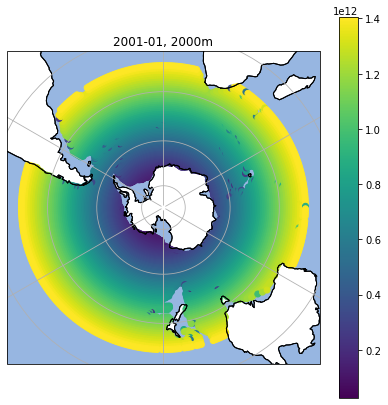

In [11]:
singleMonth = dataAreaLatLevFilt.sel(time="2001-01")
mapPlotij(singleMonth, "2001-01, 2000m", 1)

In [12]:
singleYearData = dataAreaLatLevFiltT.sel(time = slice("2001-01", "2001-12"))
singleYear = singleYearData.mean("time")
singleYear = singleYear.compute()
print("Single Year mean data calculated.")

Single Year mean data calculated.


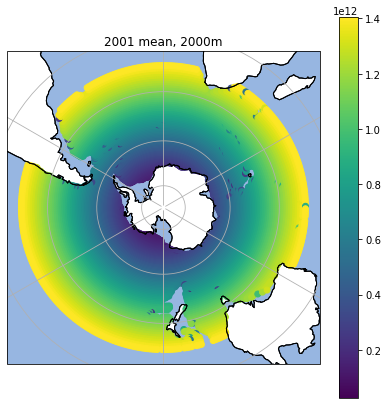

In [13]:
mapPlotij(singleYear, "2001 mean, 2000m", 1)

<br>

# Plot data of area and observe, generate mask

#### Calculating the mask

<b>Creating the mask</b><br>
Combining the filtered data with the imported mask

<br>
<b>Calculating the mask</b><br>

In [14]:
timeMaskLen = len(dataAreaLatLevFiltT["time"])
timeMask = np.zeros(timeMaskLen, dtype=bool)
timeMask[0] = True
timeMask[-1] = True
timeMask[int(timeMaskLen/2)] = True
sampleMaskData = dataAreaLatLevFiltT[timeMask]
sampleMaskData = sampleMaskData.mean("time", keep_attrs=True)
sampleMaskData = sampleMaskData.compute()
print("Volcello mask data calculated and stored in sampleMaskData.")

Volcello mask data calculated and stored in sampleMaskData.


In [15]:
maskVolcello = maskCalc(sampleMaskData)
print("Volcello mask calculated and stored in maskVolcello.")

Volcello mask calculated and stored in maskVolcello.


In [16]:
maskVolcelloRange = maskCalc(singleYearData)
print("Vocello Year mask calculated.")

Vocello Year mask calculated.


In [17]:
SeasonalDiff = maskVolcelloRange.sel(time="2001-02") - maskVolcelloRange.sel(time="2001-08")
print("Seasonal Difference in year mask calculated.")

Seasonal Difference in year mask calculated.


<br>
<b>Plotting volcello mask</b><br>

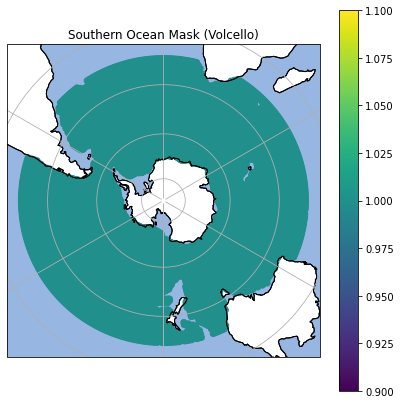

In [18]:
mapPlotij(maskVolcello, "Southern Ocean Mask (Volcello)", 1)

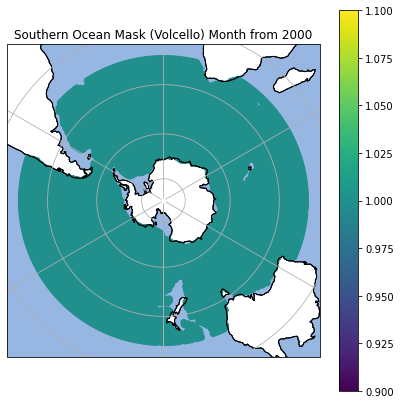

In [19]:
mapPlotij(maskVolcelloRange.sel(time="2001-04"), "Southern Ocean Mask (Volcello) Month from 2000", 1)

<br>

#### Mask comparison

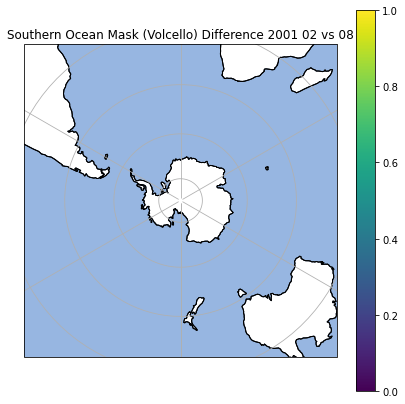

In [20]:
mapPlotij(SeasonalDiff, "Southern Ocean Mask (Volcello) Difference 2001 02 vs 08", 1)

<br>

#### Saving and reloading the mask
<b>Saving the mask</b><br>

In [22]:
maskVolcello.to_netcdf(exportMaskName)
print("Mask saved to "+exportMaskName+".")

Mask saved to OceanMaskVolcello.


<br>
<b>Reloading the mask</b><br>

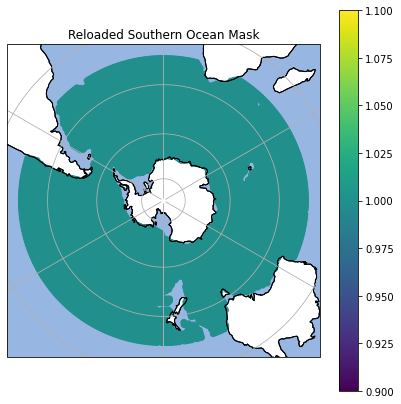

In [27]:
maskFile = xr.open_dataset(exportMaskName)
oceanMaskReload = maskFile.to_array()
mapPlotij(oceanMaskReload, "Reloaded Southern Ocean Mask", 1)

<br>
<b>Checking mask dimensions</b>

In [28]:
print("Exported mask dims: ", maskVolcello.dims)
print("Loaded mask dims: ", oceanMaskReload.dims)

Exported mask dims:  ('j', 'i')
Loaded mask dims:  ('variable', 'j', 'i')


<br>